# SVC

In [24]:
#### import packages ####

# os stuff
import sys
import os

#pandas and numpy
import pandas as pd
import numpy as np

#shap
import shap

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

In [4]:
#read the dataset
df = pd.read_csv("/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/Data/train.csv")
preprocessor(df)

In [5]:
df.head()

,EditType,EditID,comment,user,user_edit_count,user_distinct_pages,user_warns,user_reg_time,prev_user,common,...,deleted_lines,isvandalism,num_edits_5d_before,is_person,comment_empty,account_age,is_IP,word_count_added,word_count_deleted,vandalism_score
0,change,329595189,NaN,Nryan30,66,13,0,1259891940,219.78.124.42,NaN,...,NaN,False,1,0,True,0,False,131,1,4.662703e-12
1,change,232199357,/* Penis */,89.242.200.212,4,2,2,20080815230001,66.75.235.255,NaN,...,"""Falcon gained media attention after appearing...",True,4,1,False,1,True,4,202,9.809524e-01
2,change,329877752,Reverted edits by [[Special:Contributions/71.2...,Chamal N,18697,0,2,1208605428,71.208.113.72,NaN,...,""".nmbhgsdj;kfhds;akjfhds;fkjhsf;kjdshf;sdkjhfd...",False,3,0,False,595,False,34,50,2.916667e-01
3,change,253129486,NaN,Animaldudeyay1009,3,1,2,1227241317,J.delanoy,NaN,...,"""A '''kaleidoscope''' is a tube of [[mirror]]s...",True,2,0,True,0,False,94,836,1.000000e+00
4,change,394520551,Adding Persondata using [[Project:AWB|AWB]] (7...,RjwilmsiBot,1602950,1309238,0,1257977968,LobãoV,NaN,...,",",False,0,1,False,356,False,34,0,3.034339e-18


In [7]:
#select features and target
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','vandalism_score','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted']
target = 'isvandalism'

In [9]:
## set the number of CV folds
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits,
                        random_state=42,
                        shuffle=True)

## the values of C to try
Cs = [1,10,100,2000,3000,4000,5000,10000]

## this will hold the CV accuracies
C_accs1 = np.zeros((n_splits, len(Cs)))

In [11]:
## the cross-validation
# note: just svc works a tiny bit better, but LinearSVC works almost 50x faster
for i,(train_index, test_index) in enumerate(kfold.split(df, df.isvandalism)):
    df_tt = df.iloc[train_index]
    df_ho = df.iloc[test_index]

    for j,C in enumerate(Cs):
        pipe = Pipeline([('scale', StandardScaler()),
                            ('svm', LinearSVC(C=C,max_iter=100000))])

        pipe.fit(df_tt[features],
                    df_tt.isvandalism)

        pred = pipe.predict(df_ho[features])

        C_accs1[i, j] = accuracy_score(df_ho.isvandalism, pred)

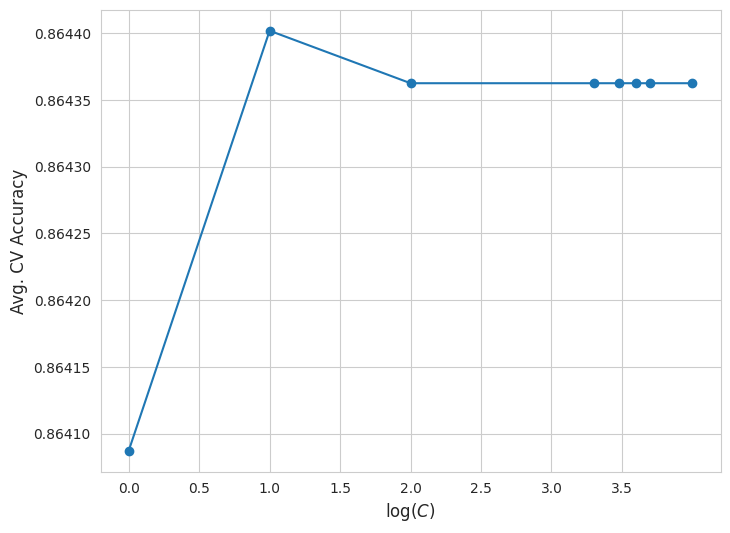

In [12]:
plt.figure(figsize = (8,6))

plt.plot(np.log10(np.array(Cs)),
         np.mean(C_accs1, axis=0),
         '-o')

plt.xlabel("$\log(C)$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)
plt.xticks(np.arange(np.log(Cs[0]),np.log10(Cs[-1]),.5),fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [13]:
mean_cv_accuracy = np.mean(C_accs1, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_C = Cs[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

print(f"The optimal C was {optimal_C} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

The optimal C was 10 which gave a mean CV accuracy of 0.864


In [27]:
#Code to create a confusion matrix
df_tt,df_ho = train_test_split(df,test_size=0.2,random_state=42,shuffle=True)

pipe = Pipeline([('scale', StandardScaler()),
                            ('svm', LinearSVC(C=optimal_C,max_iter=100000))])

pipe.fit(df_tt[features],
                    df_tt.isvandalism)

pred = pipe.predict(df_ho[features])

# Metrics
accuracy = accuracy_score(df_ho.isvandalism, pred)
precision = precision_score(df_ho.isvandalism, pred)
recall = recall_score(df_ho.isvandalism, pred)
f1 = f1_score(df_ho.isvandalism, pred)
confmat = confusion_matrix(df_ho.isvandalism, pred)

# Print metrics
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:")
print(confmat)

# Classification Report
print("\nClassification Report:")
print(classification_report(df_ho.isvandalism, pred, digits=4))

Accuracy : 0.8683
Precision: 0.8455
Recall   : 0.8938
F1 Score : 0.8689

Confusion Matrix:
[[2195  406]
 [ 264 2221]]

Classification Report:
              precision    recall  f1-score   support

       False     0.8926    0.8439    0.8676      2601
        True     0.8455    0.8938    0.8689      2485

    accuracy                         0.8683      5086
   macro avg     0.8690    0.8688    0.8683      5086
weighted avg     0.8696    0.8683    0.8682      5086



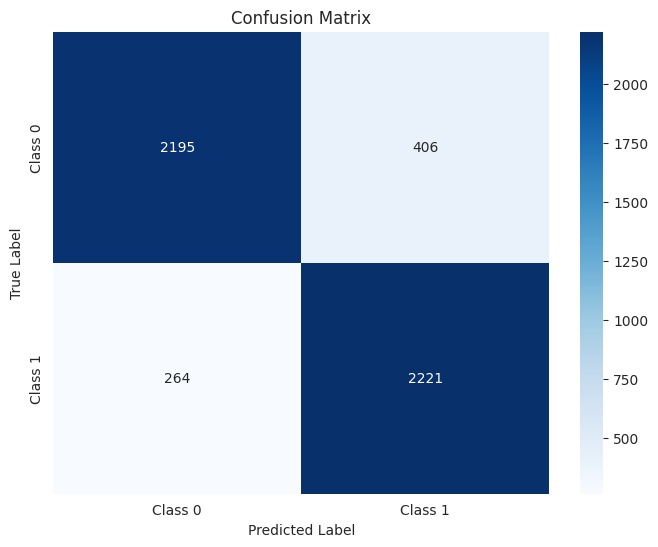

In [30]:
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()